<a href="https://colab.research.google.com/github/oacz/LS-SSDD-v1.0-OPEN/blob/master/Copy_of_Berenberg_Advanced_Document_Search_GenAI_%2B_DocAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dcoumentation

**What?**

Ask questions of a companies reports.

**Sources:**
- Annula reports

**Tools:**
- Vertex AI LLM Embedding API ('embedding-gecko@001')`
- Vertex AI GenAI Language Model API ('text@bison-001')`
- Document AI
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook


**How:**

- Load documents
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

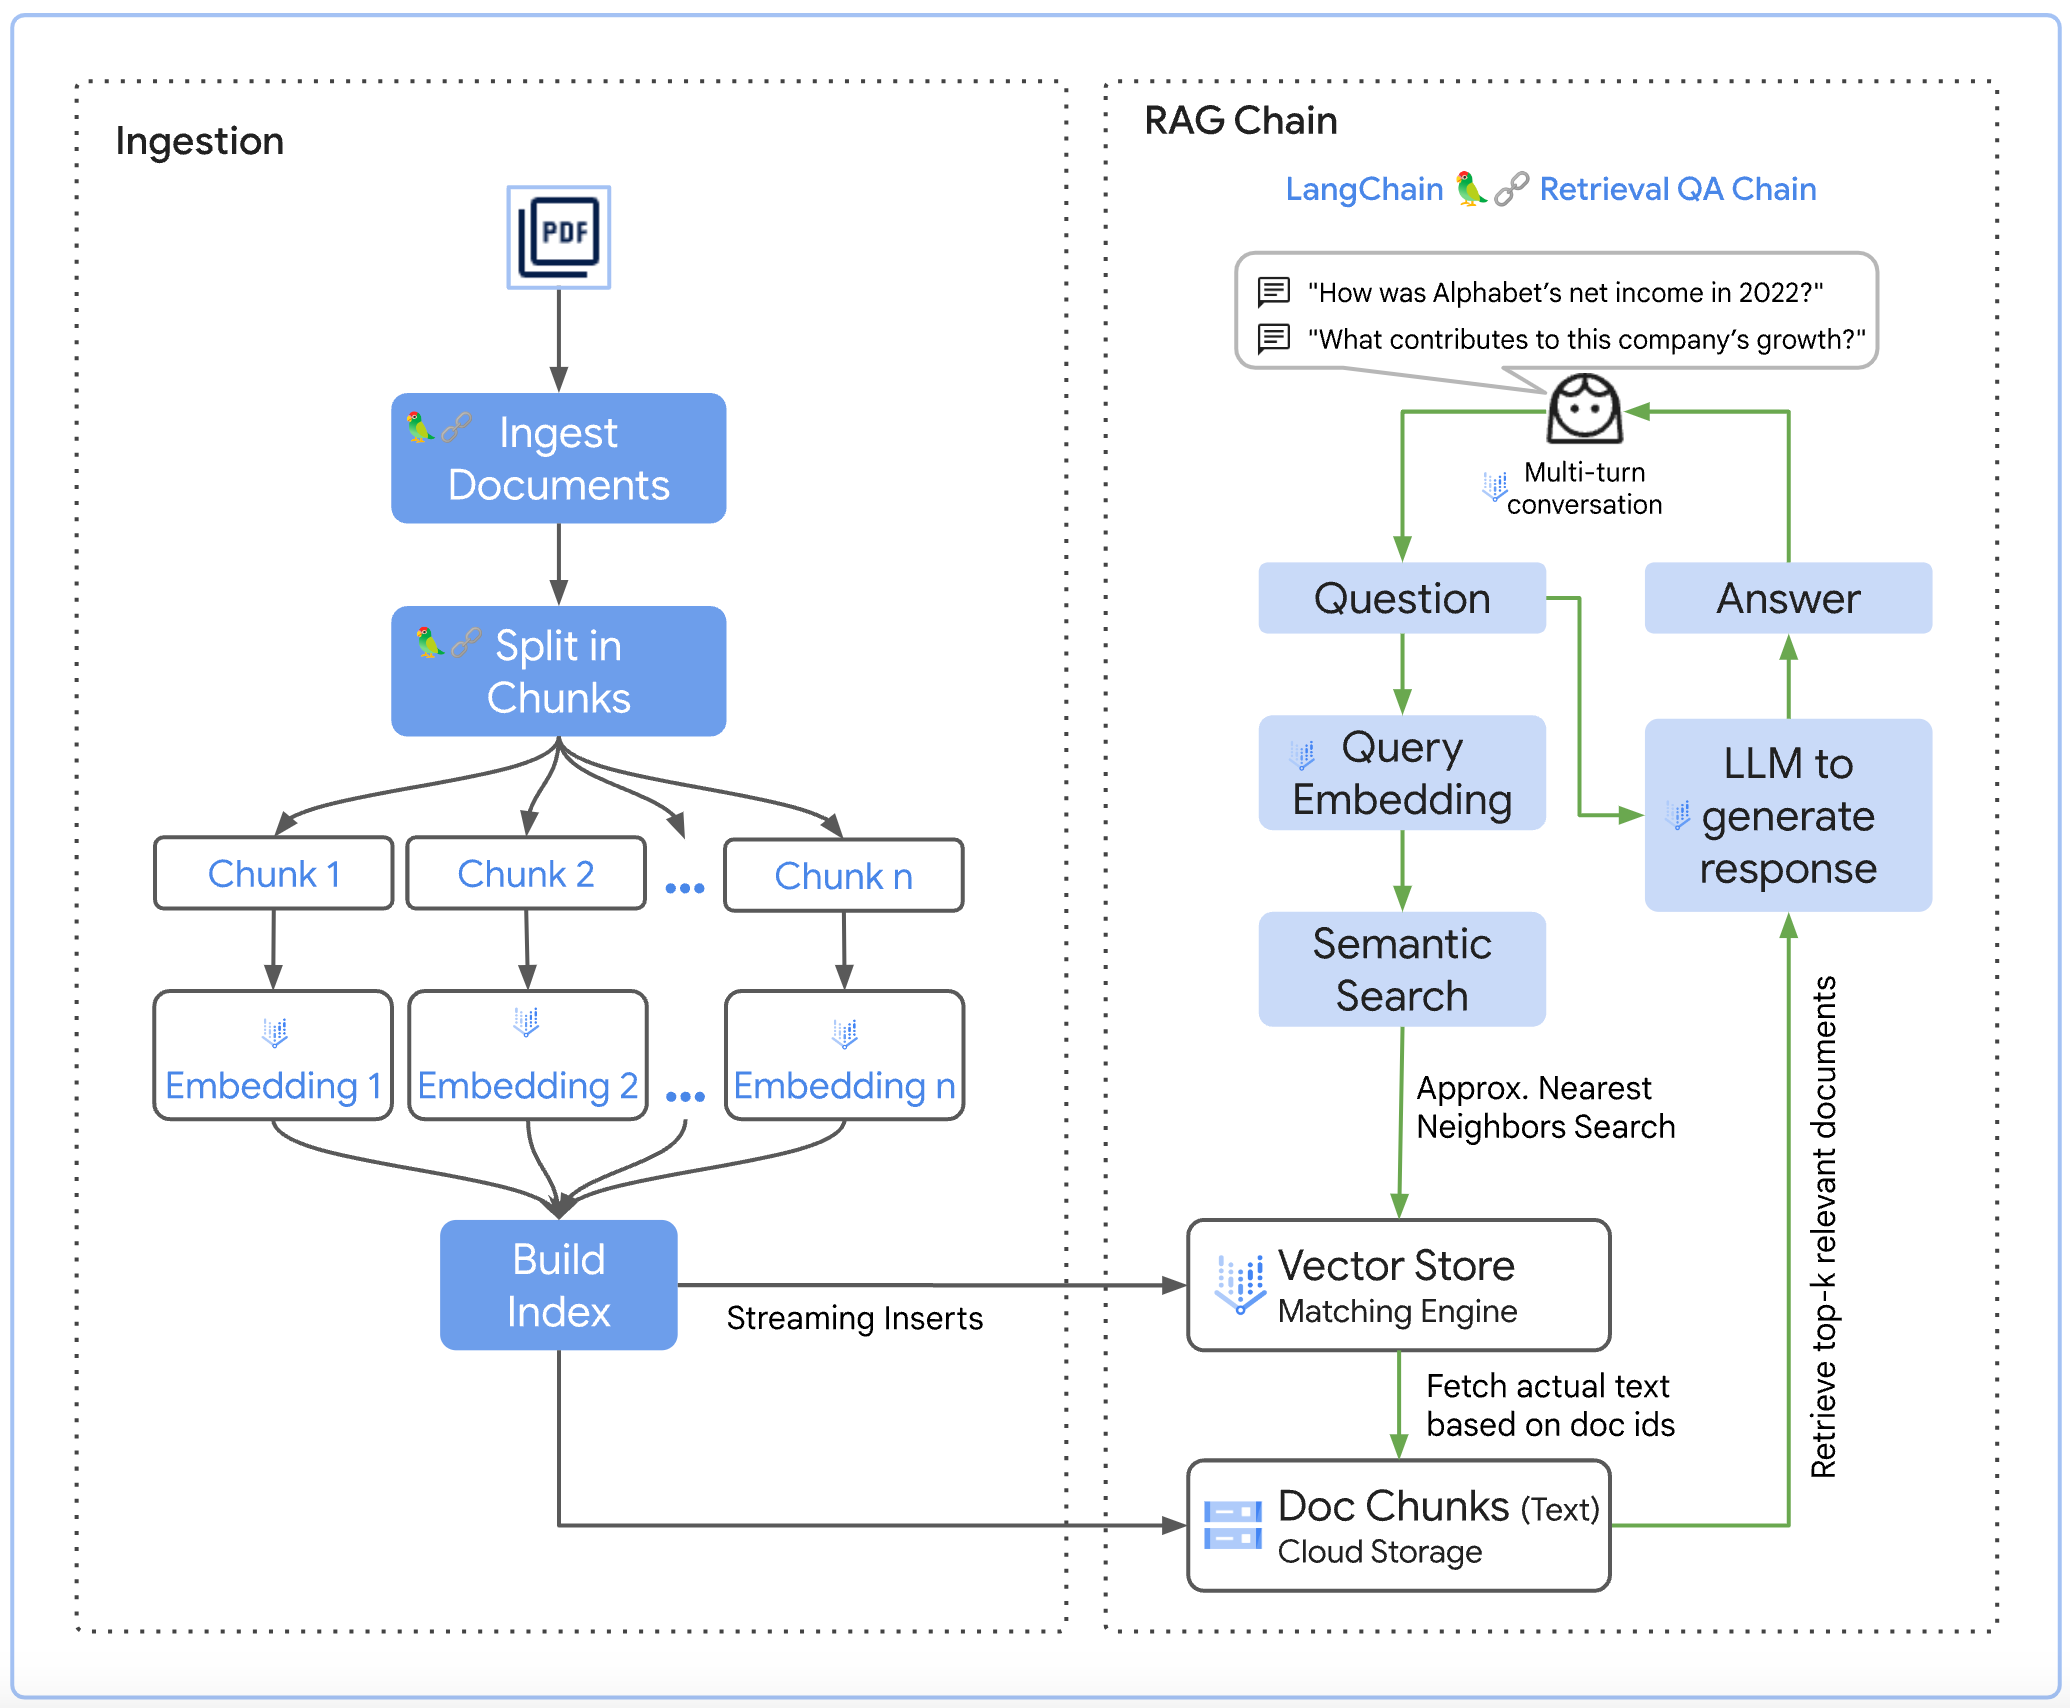


# Configurations

In [ ]:
USE_PRIOR_RUN = True
PROJECT_ID = 'bdalati' # replace with project ID
REGION = 'us-central1'
GCS_BUCKET = PROJECT_ID
source_document = f'gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf'
EXPERIMENT = 'annual-report' # list the EXPERIMENT from the choosen prerequisite notebook
SERIES = 'applied-genai'
visitor_number= 0

In [ ]:
# Authenticate
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

Updated property [core/project].


# Librarys Install

Only needed on initial run the environment.  For Colab this might be each new session.

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [ ]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [ ]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.29.0'

**RESTART RUNTIME**

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Import Packages

In [ ]:
USE_PRIOR_RUN = True
PROJECT_ID = 'bdalati' # replace with project ID
REGION = 'us-central1'
GCS_BUCKET = PROJECT_ID
source_document = f'gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf'
EXPERIMENT = 'annual-report' # list the EXPERIMENT from the choosen prerequisite notebook
SERIES = 'applied-genai'
visitor_number= 0

**Import Packages**

In [ ]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

Clients

In [ ]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [ ]:
# first question to ask
question = "how did the company's revenue and net income perform over the past year??"
embedding_model.get_embeddings([question])[0].values[0:5]

[0.010691821575164795,
 0.008824366144835949,
 -0.03249648958444595,
 -0.005674611311405897,
 0.0005513636278919876]

Test test generation (llm) model:

In [ ]:
textgen_model.predict(question)

The company's revenue and net income performed well over the past year. Revenue increased by 10%, and net income increased by 15%. This is a good sign for the company, as it shows that it is growing and becoming more profitable.

# Load and split documents

Copy the PDF to memory:

In [ ]:
bucket = gcs.bucket('bdalati-berenberg')
blob = bucket.blob('Annual report/ASML_Annual_Report_US_GAAP_2021.pdf')
response = blob.download_as_bytes()

type(response)

bytes

Split PDF in memory into a document per page (Using Python Libraries):

In [ ]:
pdf = PyPDF2.PdfReader(io.BytesIO(response))
len(pdf.pages)
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

len(pdf.pages)

281

Load previous docai parsed documents from GCS (If USE_PRIOR_RUN=True)

In [ ]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False

elif len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
    print('Copying previous run from GCS')

    # load results: the raw data from docai parsing
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    results = [json.loads(line) for line in blob.download_as_text().splitlines()]

    # load documents: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    documents = [json.loads(line) for line in blob.download_as_text().splitlines()]

    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as string, use .encode() to convert to bytes, use base64.decodebytes to decode
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        page_images.append(document_image)

    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True

else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

Copying previous run from GCS


---
# Parse Documents (IF USE_PRIOR_RUN=False)

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.

In [ ]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/357318812395/locations/us/processors/5236076d11a3a78c"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/357318812395/locations/us/processors/5236076d11a3a78c:process"
create_time {
  seconds: 1690642770
  nanos: 44398000
}
default_processor_version: "projects/357318812395/locations/us/processors/5236076d11a3a78c/processorVersions/pretrained-form-parser-v2.0-2022-11-10"

In [ ]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [ ]:
def docai_runner(p, start, raw_document):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [ ]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
    results = [None] * len(pdfs)
    start = time.time()
    with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
        futures = [
            executor.submit(
                docai_runner,
                p, start,
                documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
            ) for p, pdf in enumerate(pdfs)
        ]
        for future in concurrent.futures.as_completed(futures):
          #result = futures[future]
          results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

Using Prior Results


In [ ]:
len(pdfs), len(results)

(281, 281)

In [ ]:
if PRIOR_PARSE:
  print('Using Prior Documents Preparation')
else:
  documents = []
  page_images = []
  for r, result in enumerate(results):

    # add order to results:
    results[r]['metadata'] = dict(vme_id = str(r))

    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]

      vertices = []
      for vertex in table['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
      tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  vme_id = str(len(documents)),
                  filename = source_document.split('/')[-1],
                  source_document = source_document
              ),
              extras = dict(
                  #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      # only use paragraph that are not within table boundaries
      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    vme_id = str(len(documents)),
                    filename = source_document.split('/')[-1],
                    source_document = source_document
                ),
                extras = dict(
                    #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                    vertices = vertices
                )
            )
        )

len(documents)

Using Prior Documents Preparation


3762

In [ ]:
print(documents[300]['page_content'])

To make sure that every individual pattern on an integrated
circuit is connected flawlessly, we provide advanced
process control solutions through our metrology and
inspection systems and computational lithography
solutions. In addition, we support our growing installed
base with best-in-class customer support. Our highly
differentiated solutions provide unique value drivers for our
customers and ASML, working together to enable
affordable shrink well into the next decade.
T


In [ ]:
print(documents[300]['metadata'])
print(documents[10])

{'page': 22, 'paragraph': 7, 'vme_id': '300', 'filename': 'ASML_Annual_Report_US_GAAP_2021.pdf', 'source_document': 'gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf'}
{'page_content': 'Our position in the semiconductor value chain\n1', 'metadata': {'page': 2, 'paragraph': 8, 'vme_id': '10', 'filename': 'ASML_Annual_Report_US_GAAP_2021.pdf', 'source_document': 'gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf'}, 'extras': {'vertices': [{'x': 211.00001092999997, 'y': 719.99999632}, {'x': 805.00002003, 'y': 717.00000664}, {'x': 805.00002003, 'y': 740.99997164}, {'x': 211.00001092999997, 'y': 744.00003266}]}, 'embedding': [-0.03353005647659302, -0.0025599454529583454, 0.0026986191514879465, 0.024482225999236107, 0.013294724747538567, -0.014831498265266418, 0.02449720725417137, 0.0014267840888351202, -0.013623746111989021, -0.0158753152936697, 0.02232550084590912, -0.007680418901145458, 0.0055315252393484116, -0.008660946041345596, 0.04508734

# Get Embeddings


In [ ]:
rate_limit_minute = 150

In [ ]:
if PRIOR_PARSE:
  print('Embeddings created on previous run.')
else:
  print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
  start = time.time()
  for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

Embeddings created on previous run.


Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [ ]:
index = np.empty((len(documents), len(documents[0]['embedding'])))
index.shape

(3762, 768)

In [ ]:
type(results) == list

True

In [ ]:
if type(documents[0]['embedding']) == list:
    for i in range(index.shape[0]):
        if documents[i]['page_content']:
            index[i] = documents[i]['embedding']

In [ ]:
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [ ]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [ ]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [ ]:
search_index(question, 4)

[(2355, 0.7165049), (2720, 0.7032121), (1687, 0.6901181), (2722, 0.6837274)]

In [ ]:
score = search_index(question, k = 1)[0][1]
search_index(question, k = 1 + 2*int(10*(1-score)))

[(2355, 0.7165049),
 (2720, 0.7032121),
 (1687, 0.6901181),
 (2722, 0.6837274),
 (670, 0.67936575)]

---
Save For Future Runs: GCS

In [ ]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
        print('Writing contents of results and documents to GCS for future use.')

        # save results: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
        blob.upload_from_string('\n'.join([json.dumps(result) for result in results]), content_type = 'application/json')

        # save documents: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
        blob.upload_from_string('\n'.join([json.dumps(document) for document in documents]), content_type = 'application/json')

This run loaded results from a prior run.  Not overwriting.


Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [ ]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/embeddings.json')
    blob.upload_from_string('\n'.join(
        [
            json.dumps(
                dict(
                    id = document['metadata']['vme_id'],
                    embedding = document['embedding'],
                    restricts = [dict(namespace = SERIES, allow = [EXPERIMENT])]
                )
            ) for document in documents
        ]
    ), content_type = 'application/json')

This run loaded results from a prior run.  Not overwriting.


---
# Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Checks to see if the section closest to the response/answer was included in the sections of the rules provided in the prompt.
- Prepares and presents all the information back to the user

In [ ]:
!pip install beautifulsoup4

In [ ]:
page_image_file = None

def document_bot(question, max_output_tokens = 300):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]

    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    # prepare context for prompt
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])

    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.

        {context}

        Question:
        {question}

        Answer and Explanation:
    """

    #print(prompt)

    # retrieve response
    response = textgen_model.predict(prompt, max_output_tokens = max_output_tokens)

    # get closest document to the response:
    likely_source = search_index(response, k=1)[0]

    # declare likely source: if closest document to response was in context pick it, otherwise pick first context match
    if likely_source[0] in [rd[0] for rd in relevant_documentation]:
        likely = True
        likely_document = documents[likely_source[0]]
    else:
        likely = False
        likely_document = documents[relevant_documentation[0][0]]


    sources = "\n".join(f"* {documents[doc[0]]['metadata']['source_document']}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)
    global answer
    answer = f"""## Response
### Question
{question}
### Answer
{response}
### Why?
{likely_document['page_content']}
* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[1]:.2f}
* {likely_document['metadata']['source_document']}#page={likely_document['metadata']['page']}
### Sources
{sources}
    """
    IPython.display.display(IPython.display.Markdown(answer))

    from bs4 import BeautifulSoup
    from markdown import markdown

    global response_answer
    global response_page_content
    global response_source_document
    global response_sources
    global response_sources_parsed

    response_answer = response
    response_page_content = likely_document['page_content']
    response_source_document = likely_document['metadata']['source_document'] +" page:" + str(likely_document['metadata']['page'])
    response_sources = sources

    response_sources_parsed = ''
    for item in response_sources.splitlines():
      if item.find("Document:") != -1:
        response_sources_parsed = str(response_sources_parsed) + '\n' + str(item.replace(",", "       "))
    #print(response_sources_parsed)

    #font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
    document_image = page_images[likely_document['metadata']['page']-1]
    vertices = documents[int(likely_document['metadata']['vme_id'])]['extras']['vertices']
    draw = PIL.ImageDraw.Draw(document_image).polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
    ], outline = 'green', width = 5)
    IPython.display.display(document_image.resize((600, 700)))

    page_image_file = document_image.resize((600, 700))
    page_image_file.save("page_image.jpg")
    #print(context)
    global visitor_number
    visitor_number = visitor_number + 1
    return

In [ ]:
textgen_model.predict(question)

The company's revenue and net income performed well over the past year. Revenue increased by 10%, and net income increased by 15%. This is a good sign for the company, as it shows that it is growing and becoming more profitable.

In [ ]:
#print(response_answer)
#print(response_page_content)
#print(response_source_document)
#print(response_sources)
#response_sources.index("Document")
#response_sources[response_sources.index("Document"):10000]
print(visitor_number)

0


## Response
### Question
how did the company's revenue and net income perform over the past year??
### Answer
The company's revenue and net income performed well over the past year. Net sales increased by 107% since 2017, and net income increased by 185% since 2017.
### Why?
Financial and operational performance
We reviewed the annual and interim financial statements,
including non-financial information, the quarterly results
and accompanying press releases, as well as the
outcomes of the year-end US GAAP and EU-IFRS audits.
A
* page: 145, relevance to answer: 0.83
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=145
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=145
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 145, relevance to question: 0.72
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=170
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 170, relevance to question: 0.70
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=103
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 103, relevance to question: 0.69
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=170
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 170, relevance to question: 0.68
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=47
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 47, relevance to question: 0.68
    

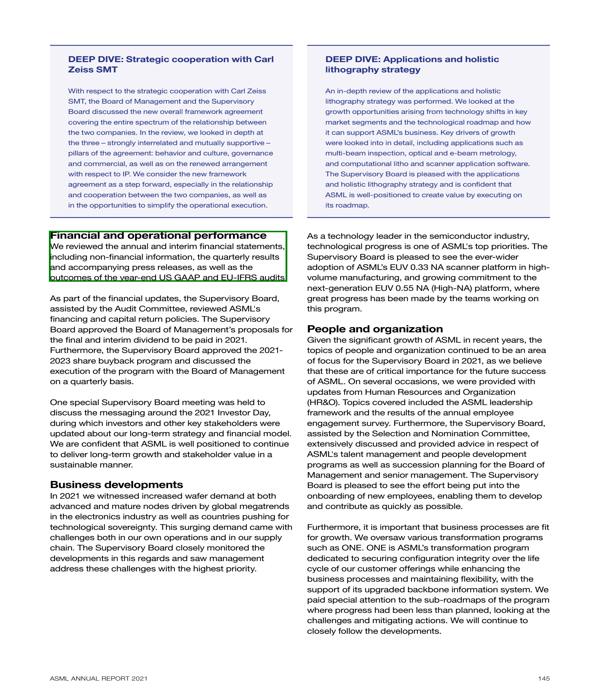

In [ ]:
document_bot(question)

# start gradio server

In [ ]:
pip install gradio

  Attempting uninstall: markdown-it-py
    Found existing installation: markdown-it-py 3.0.0
    Uninstalling markdown-it-py-3.0.0:
      Successfully uninstalled markdown-it-py-3.0.0
  Attempting uninstall: mdit-py-plugins
    Found existing installation: mdit-py-plugins 0.4.0
    Uninstalling mdit-py-plugins-0.4.0:
      Successfully uninstalled mdit-py-plugins-0.4.0


In [ ]:
import gradio as gr
import requests
from PIL import Image
import gradio as gr
from io import BytesIO
import json
import logging

logging.basicConfig(filename='./log.log', filemode='w', level=logging.DEBUG)

def echo(name, request: gr.Request):
    print("Request headers dictionary:")
    if request:
        print("Request headers dictionary:", request.headers)
        logging.info("Request headers dictionary:", request.headers)
        logging.info("IP address:", request.client.host)
    return name

def authorize(username, password):
    if username == "googlegenai" and password == "transformers2017":
      return True
    else:
      return False

def flip_app(input, slider,request: gr.Request):
    document_bot(input)
    imagepage = Image.open("./page_image.jpg")
    with open("visitors.log", "a+") as f:
      f.write(request.client.host + '\n')
    return     response_answer,response_page_content,response_source_document,response_sources_parsed,imagepage


def flip_document(x):
    arc_imagepage = Image.open("./architecture.png")
    return     arc_imagepage

html = '''
<a class="btn btn-primary" href="http://34.68.179.227/">Home Menu</a><br/><br/>
<h1>Document Advanced Search</h1>
<b>Powered by Google Gernerative AI LLM, DocAI, Langchain, MatchingEngine, Embeddings API</b><br/><br/>

<b>Quick start:</b> click on one of the examples at the buttom of the page or write your own
'''

details = '''
<b>Indexed Documents:</b>This Demo is based on ASML Finanacial reports documents<br/>
<b>Output:</b> Answer ==> Why it reached this answer ==> Page source ==> Other Sources with relevance score ==>Image of the source page with green bounding box<br/><br/>

For more Info: Click on the Document Tab
'''

script = '''
function test(){
    let script = document.createElement('script');
    script.innerHTML = "function click_text(){alert('click')}";
    document.head.appendChild(script);
}
'''

document = '''
<h1>Architecture</h1>
<!--<img src="./architecture.png" alt="RAG Architecture" width="500" height="600">-->

<h3>What?</h3>
Ask questions of a companies reports.</br>

<h3>Sources:</h3>
Annula reports

<h3>Tools:</h3>
Vertex AI LLM Embedding API ('embedding-gecko@001')`</br>
Vertex AI GenAI Language Model API ('text@bison-001')`</br>
Document AI</br>
Embedding search: with ScaNN, chromadb, Vertex AI Matching Engine</br>

<h3>How:</h3>
Load documents</br>
Create embeddings for each document</br>
Ask a question</br>
Create an embedding of the question</br>
Use vector similarity to retrieve embeddings for related documents</br>
Retrieve the documents associated with returned embeddings</br>
Prepare a prompt to answer the question using the documents as context</br>
Present the response as an answer with links to the related documents (sections of the document).</br>

<h3>construct the prompt:</h3>
    prompt = f"""</br>
        Give a detailed answer to the question using information from the provided contexts.</br>
</br>
        {context}</br>
</br>
        Question:</br>
        {question}</br>
</br>
        Answer and Explanation:</br>
    """
'''

css = """
.h1 text-align: center;
#warning {background: red;}
.feedback {background: orange !important;}
.feedback textarea {font-size: 24px !important;}
"""

with gr.Blocks(css=css) as demo:
    gr.HTML(html)

    with gr.Accordion("Open for More!"):
        gr.HTML(details)

    with gr.Tab("App"):
      with gr.Row():
        with gr.Column():
          inputs=[
            gr.inputs.Textbox(lines=3, label="Prompt"),
            gr.Slider(0, 1, 0.2,label="Temprature")]
          text_button = gr.Button("Submit", elem_classes="feedback")

          examples=[["How did revenue and net income of ASML in 2020 perform compared to 2021?",0.2],
                  ["Did ASML meet its financial targets or analyst expectations for 2021?",0.2],
                  ["What were the key drivers behind any significant changes in revenue or profitability fro ASML in year 2021?",0.2],
                  ]

          gr.Examples(
              examples,
              inputs,
          )

        with gr.Column():
          outputs=[
                  gr.outputs.Textbox(label="Response"),
                  gr.outputs.Textbox(label="Why"),
                  gr.outputs.Textbox(label="Source Document"),
                  gr.outputs.Textbox(label="Other Sources"),
                  gr.outputs.Image(type='pil', label="Source Image")]


    with gr.Tab("Document"):
        with gr.Row():
          gr.HTML(document)

    text_button.click(flip_app, inputs=inputs, outputs=outputs)


if __name__ == "__main__":
    demo.launch(auth=("googlegenai", "transformers2017"),debug=True)
    #io = demo.launch(echo,debug=True)




<ipython-input-151-c524f53407a8>:114: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.inputs.Textbox(lines=3, label="Prompt"),
<ipython-input-151-c524f53407a8>:114: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  gr.inputs.Textbox(lines=3, label="Prompt"),
<ipython-input-151-c524f53407a8>:114: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  gr.inputs.Textbox(lines=3, label="Prompt"),
<ipython-input-151-c524f53407a8>:130: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  gr.outputs.Textbox(label="Response"),
<ipython-input-151-c524f53407a8>:131: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.com

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


In [ ]:
import gradio as gr
import requests
from PIL import Image
import gradio as gr
from io import BytesIO
import json


def flip_app(x):
    return x[::-1]


def flip_document(x):
    return np.fliplr(x)


with gr.Blocks() as demo:
    gr.Markdown("For more Info: Click on the Document Tab")
    with gr.Tab("App"):
        inputs= [
                gr.inputs.Textbox(lines=3, label="Prompt"),
                gr.Slider(0, 1, 0.2,label="Temprature (non functional yet)")
                ],
        outputs=[
                gr.outputs.Textbox(label="Response"),
                gr.outputs.Textbox(label="Why"),
                gr.outputs.Textbox(label="Source Document"),
                gr.outputs.Textbox(label="Other Sources"),
                gr.outputs.Image(type='pil', label="Source Image")],
        examples=[["How did revenue and net income of ASML in 2020 perform compared to 2021?"],
                  ["Did ASML meet its financial targets or analyst expectations for 2021?"],
                  ["What were the key drivers behind any significant changes in revenue or profitability fro ASML in year 2021?"],
                  ],
        text_button = gr.Button("Submit")
    with gr.Tab("Document"):
        with gr.Row():
            image_input = gr.Image()
            image_output = gr.Image()
        image_button = gr.Button("Flip")

    with gr.Accordion("Open for More!"):
        gr.Markdown("Look at me...")

    text_button.click(flip_app, inputs=inputs, outputs=outputs)
    image_button.click(flip_document, inputs=image_input, outputs=image_output)

if __name__ == "__main__":
    demo.launch()



title = "Document Advanced Search"
description = """####   Powered by Google Gernerative AI LLM, DocAI, Langchain, MatchingEngine, Embeddings API

<b>Indexed Documents:</b>This Demo is based on ASML Finanacial reports documents (has two documents now, adding 12 more soon)

<b>Output:</b> Answer ==> Why it reached this answer ==> Page source ==> Other Sources with relevance score ==>Image of the source page with green bounding box

let me know your feedback bdatai@

<b> Quick start:</b> click on one of the examples at the buttom of the page or write your own
"""

css = """#warning {background-color: #FFCCCB} .feedback textarea {font-size: 24px !important}"""

def generate(input, slider):
    document_bot(input)
    imagepage = Image.open("./page_image.jpg")
    return     response_answer,response_page_content,response_source_document,response_sources_parsed,imagepage

demo=gr.Interface(
    fn=generate,
    inputs= [
            gr.inputs.Textbox(lines=3, label="Prompt"),
            gr.Slider(0, 1, 0.2,label="Temprature (non functional yet)")
            ],
    outputs=[
            gr.outputs.Textbox(label="Response"),
            gr.outputs.Textbox(label="Why"),
            gr.outputs.Textbox(label="Source Document"),
            gr.outputs.Textbox(label="Other Sources"),
            gr.outputs.Image(type='pil', label="Source Image")],
    examples=[["How did revenue and net income of ASML in 2020 perform compared to 2021?"],
              ["Did ASML meet its financial targets or analyst expectations for 2021?"],
              ["What were the key drivers behind any significant changes in revenue or profitability fro ASML in year 2021?"],
              ],
    cache_examples=False,
    title = title,
    description = description,
    css=css
  )


gr.close_all()
demo.launch()
#demo.launch(share=True)

ModuleNotFoundError: ignored

# Run other examples

## Response
### Question
What were the key drivers behind any significant changes in revenue or profitability fro ASML in year 2021?
### Answer
The key drivers behind any significant changes in revenue or profitability for ASML in year 2021 were the surge in customer demand, the ability of ASML to deliver in order to meet this demand and the potential impact on the financial figures.
### Why?
The operational and financial short- and long-term performance of ASML was discussed extensively, looking at various
performance scenarios and their impact on ASML's results, cash generation, and financing and capital return policies.
Particular item of focus in 2021 was the surge in customer demand, the ability of ASML to deliver in order to meet this
demand and the potential impact on the financial figures.
T
* page: 152, relevance to answer: 0.89
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=152
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=152
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 152, relevance to question: 0.80
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=41
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 41, relevance to question: 0.77
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=42
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 42, relevance to question: 0.76
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=160
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 160, relevance to question: 0.76
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=156
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 156, relevance to question: 0.76
    

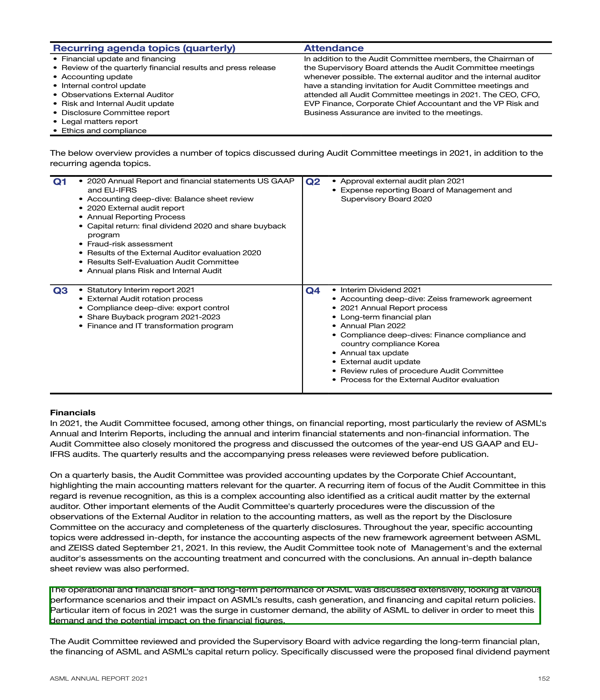

In [ ]:
document_bot("What were the key drivers behind any significant changes in revenue or profitability fro ASML in year 2021?")

## Response
### Question
Did ASML meet its financial targets or analyst expectations for 2021?
### Answer
Yes, ASML met its financial targets and analyst expectations for 2021. ASML had a record year in 2021, with record turnover, cash flow and profitability. The company also saw strong growth in its leading-edge EUV lithography systems, as well as in DUV, the workhorse of the semiconductor industry in mature nodes. To meet this strong demand across its entire product portfolio, ASML is driving down its manufacturing cycle times and is working with its supply chain to increase its output capability across its product portfolio. In 2021, ASML also saw some tension in its operations as well as in ASML's supply chain, which caused some delays in system shipments at the end of the year. However, with ASML's typical ‘let's just do it' mentality, these issues have been addressed with the highest priority.
### Why?
Message from the Chair of
our Supervisory Board
year. However, with ASML's typical ‘let's just do it'
mentality, these issues have been addressed with the
highest priority.
Aligning with customers
In the context of being a trusted partner in the
semiconductor ecosystem, ASML has seen great
progress in dialogues with leading customers on EUV 0.33
NA and EUV 0.55 NA (High-NA). Particularly in EUV, it is
important for ASML to be totally transparent toward its
customers, because they have no alternative. Instead of
just selling equipment, ASML works with its customers
toward achieving a speci wafer output - this requires
total alignment with customers' objectives, which may be
different depending on how they run their factories. ASML
always needs to adapt to that, thinking from its customers'
perspective and being fully aligned to address their needs
with its products and services.
Gerard Kleisterlee (Chair of the Supervisory Board)
Dear Stakeholder,
In 2021, ASML had stellar performance - driven by
strongly surging demand for microchips, it was a record
year, again under adverse circumstances. We still had to
cope with COVID-19 and some supply issues, but we saw
fantastic growth, making 2021 an even better year than
2020 with record turnover, cash flow and profitability.
Maintaining a well-functioning global semiconductor
ecosystem
ASML operates in a world that is getting more complex.
Also in 2021, with chips being at the core of modern digital
life, ASML has been a topic in the ongoing trade
discussions between the world's superpowers. ASML
takes up a neutral position in this. The starting point here
has been and will be that ASML aims to work with its
customers in a way that allows the company to continue to
Impressive technological progress
serve all of them, wherever they are, within all applicable
Success of the company starts with the success that
rules and regulations. We strongly believe that it is in the
ASML has with its customers. We have seen great
interest of all stakeholders in the semiconductor and
progress with the wide adoption of ASML's EUV 0.33 NA
electronics industry to avoid fragmentation and maintain a
platform in high-volume manufacturing, and growing
well-functioning global ecosystem, based on cooperation,
commitment to the next-generation EUV 0.55 NA (High-
fair competition and trust.
NA) platform, where good technical advances have been
made. At the start of Q4, the Supervisory Board's
Technology Committee made a visit to ZEISS in Germany,
Increasing focus on ESG sustainability
where preparations for assembly of the first new system
ASML takes today's increasing focus on ESG
are being executed, and we were impressed by the great
achievements of the teams working on this.
Dealing with surging demand
(environment, social and governance) sustainability very
seriously. We take responsibility for what we do and can
control. On the social and governance aspects - we are
taking care of our employees and the communities that we
We continue to see surging demand, not only for our
are in, and we are well governed. The environmental
leading-edge EUV lithography systems, but also for DUV,
the workhorse of the semiconductor industry in mature
nodes. To meet this strong demand across our entire
product portfolio, we are first of all driving down our
manufacturing cycle times and are working with our
aspect is primarily about addressing climate change,
which is a global challenge that requires urgent action by
everyone, including us. We have to take care of our own
environmental footprint, the footprint of our suppliers and
the potential negative effects of the products and services
supply chain to increase our output capability acros
product portfolio. In 2021, we have seen some tension in
our operations as well as in ASML's supply chain, which
that we supply. We ask our suppliers to show their
environmental programs, and we work with them on joint
programs in areas such as re-use. On our side, it is our
our
caused some delays in system shipments at the end of the
responsibility to minimize the energy consumption,

* page: 142, relevance to answer: 0.89
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=142
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=152
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 152, relevance to question: 0.78
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=167
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 167, relevance to question: 0.77
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=160
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 160, relevance to question: 0.76
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=142
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 142, relevance to question: 0.76
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=44
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 44, relevance to question: 0.76
    

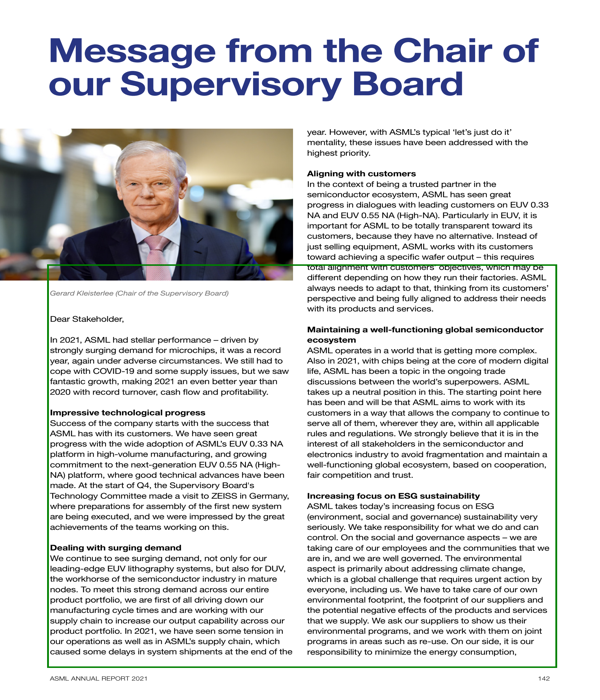

In [ ]:
document_bot("Did ASML meet its financial targets or analyst expectations for 2021?")

## Response
### Question
What is this document?
### Answer
The document is the 2021 Annual Report on Form 20-F for ASML Holding N.V.
### Why?
Appendix - Government regulation
O
* page: 263, relevance to answer: 0.86
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=263
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=263
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 263, relevance to question: 0.66
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=272
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 272, relevance to question: 0.65
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=267
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 267, relevance to question: 0.65
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=145
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 145, relevance to question: 0.64
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=35
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 35, relevance to question: 0.64
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=271
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 271, relevance to question: 0.64
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=258
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 258, relevance to question: 0.63
    

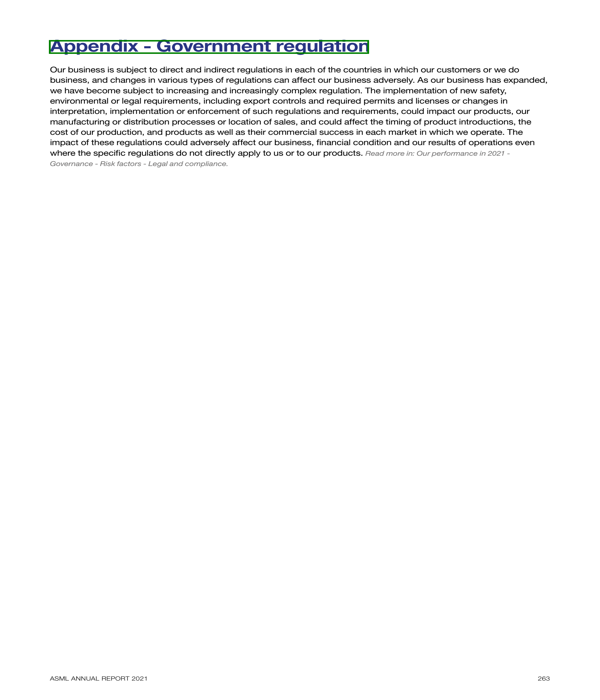

In [ ]:
document_bot('What is this document?')

## Response
### Question
What is the company's current asset and liability structure?
### Answer
The company's current assets are cash and cash equivalents, short-term investments, accounts receivable, finance receivables, current tax assets, contract assets, inventories, and other assets. The company's current liabilities are accounts payable, accrued and other liabilities, current tax liabilities, current portion of long-term debt, contract liabilities, and total current liabilities.
### Why?
Accounts payable 4
1,Accrued and other liabilities
151,377.9
2,15
1,146.0
1,2,116.3
Ac1,435.5
Current tax liabilities
21
110.0
301262
Cu301.9
12Current portion of long-term debt
16
15.4
509.1
Contract liabilities
3,954.2
7,935.2
Total current liabilities
6,603.5
12,298.0
Lo
* page: 179, relevance to answer: 0.85
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=179
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=179
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 179, relevance to question: 0.70
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=136
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 136, relevance to question: 0.69
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=221
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 221, relevance to question: 0.68
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=271
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 271, relevance to question: 0.67
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=179
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 179, relevance to question: 0.67
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=95
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 95, relevance to question: 0.66
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=190
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 190, relevance to question: 0.66
    

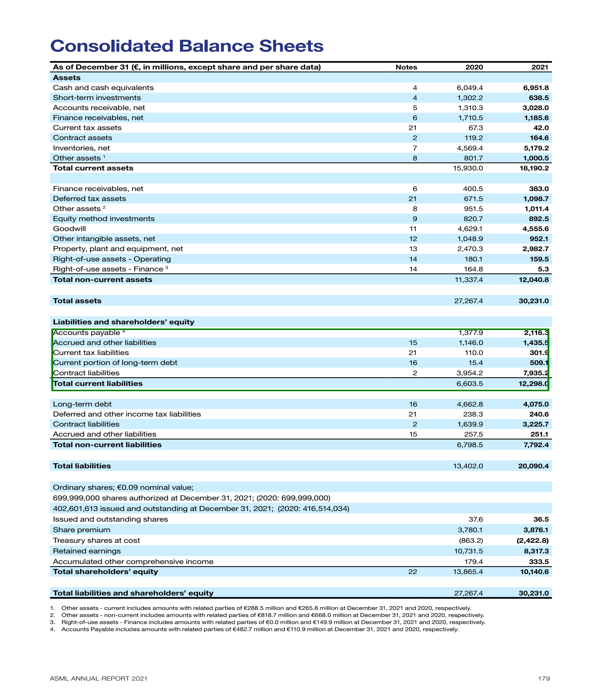

In [ ]:
document_bot("What is the company's current asset and liability structure?")

## Response
### Question
How has the company's working capital position evolved?
### Answer
The company's working capital position has evolved positively. The company has sufficient working capital for the company's present requirements. The company's working capital position has improved due to the increase in net cash provided by operating activities, which is mainly due to an increase in net income and increase in down payments from our customers in connection with our continued working capital improvement initiatives.
### Why?
Net cash provided by (used in) operating activities
The significant increase in Net cash provided by operating activities of €6.2 billion compared to 2020, is mainly due to an
increase in Net income of €2.3 billion and increase in down payments from our customers in connection with our
continued working capital improvement initiatives.
N
* page: 47, relevance to answer: 0.84
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=47
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=47
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 47, relevance to question: 0.70
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=47
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 47, relevance to question: 0.69
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=121
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 121, relevance to question: 0.69
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=9
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 9, relevance to question: 0.68
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=47
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 47, relevance to question: 0.68
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=191
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 191, relevance to question: 0.67
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=164
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 164, relevance to question: 0.67
    

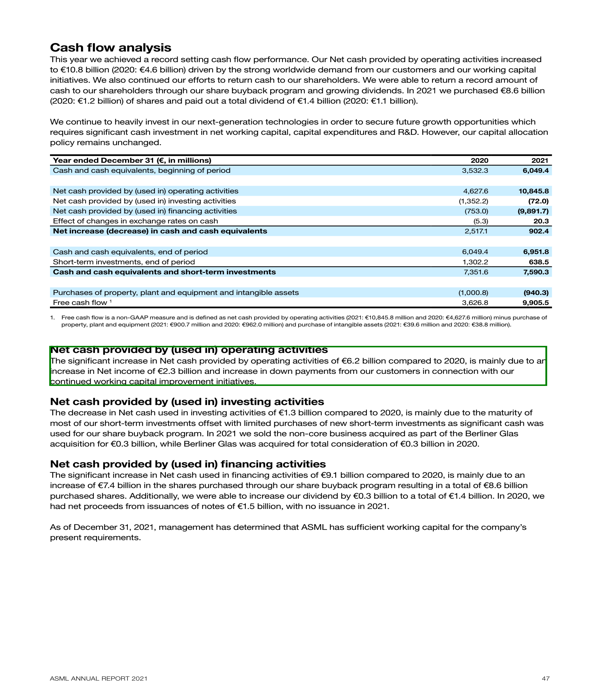

In [ ]:
document_bot("How has the company's working capital position evolved?")

## Response
### Question
Which yard or terminal had the highest annual volume?
### Answer
The answer is not in the passage.
### Why?
manufacturing capacity, especially in 'More-than-
h
* page: 65, relevance to answer: 0.66
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=65
### Sources
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=65
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 65, relevance to question: 0.64
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=204
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 204, relevance to question: 0.62
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=257
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 257, relevance to question: 0.61
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=79
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 79, relevance to question: 0.61
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=51
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 51, relevance to question: 0.61
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=71
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 71, relevance to question: 0.61
* gs://bdalati-berenberg/Annual report/ASML_Annual_Report_US_GAAP_2021.pdf#page=204
	* Document: ASML_Annual_Report_US_GAAP_2021.pdf, page: 204, relevance to question: 0.61
    

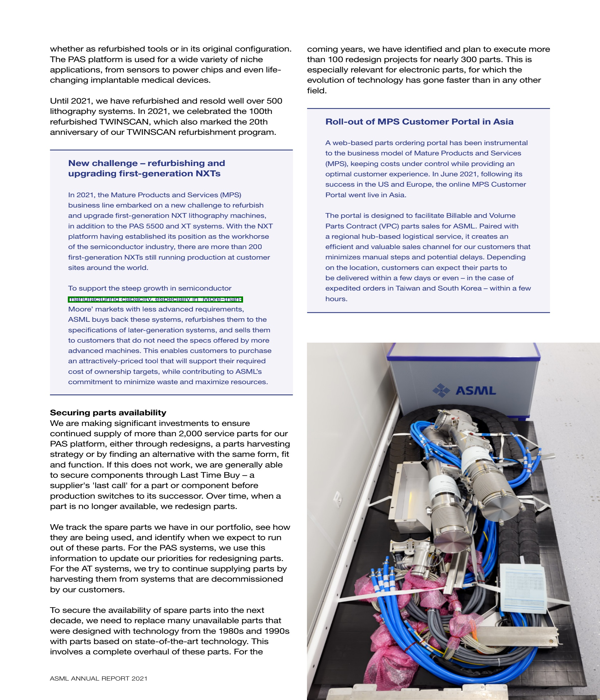

In [ ]:
document_bot("Which yard or terminal had the highest annual volume?")